In [15]:
import sys
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

project_root = str(Path.cwd().parent.parent.parent)

if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary modules
from src.models.custom_functions import (
    SafeIdentityFunction, SafeLog, SafeExp,
    SafeSin, SafePower, SafeCos
)
from src.training.trainer import Trainer
from src.training.connectivity_trainer import ConnectivityTrainer
from src.utils.plotting import plot_results
from src.utils.data_utils import get_data_loaders, generate_astro_data
from src.models.model_initialization import initialize_model

from src.utils.astro_utils import *


In [16]:
def fn_train(train_loader, val_loader):
    # Define the set of functions
    function_set = {
            "identity": SafeIdentityFunction(),
            "exp": SafeExp(),
            "log": SafeLog(),
            "sin": SafeSin(),
            "cos": SafeCos(),
            "power": SafePower(),
            # Idea: Add "x" function just to know x in the layer
        }

    # Training configuration
    config = {
        'training': {
            'num_epochs': 1000,
            'learning_rate': 0.01,
            'reg_strength': 0.0001,
            'decimal_penalty': 0.01,
            'scheduler': 'progressive',  # One of: cosine, cyclic, progressive
            # Connectivity training specific parameters
            'use_connectivity_training': False,  # Set to False for classical training
            'max_architectures': 10,
            'max_patterns_per_layer': 5,
            'num_parallel_trials': 1,
            'print_training_stats': True
        }
    }

    # Model configuration
    input_size = 1
    output_size = 1
    num_layers = 2
    nonlinear_info = [(1, 0), (0, 0), (0, 0)]


    model = initialize_model(
        input_size,
        output_size, 
        num_layers,
        function_set, 
        nonlinear_info, 
        min_connections_per_neuron=1, 
        exp_n=1001)

    # Train the model using original trainer
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        device=device
    )
    trainer.train()
    trained_model = model
    return trained_model

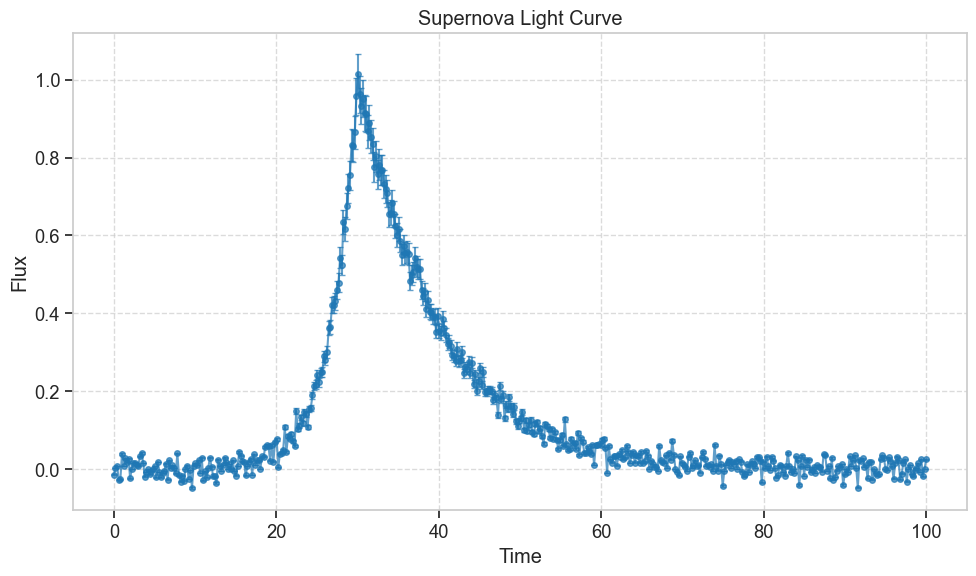

In [17]:
lc_supernova = create_sample_light_curve(n_points=500, curve_type='supernova')
# Visualize each type
visualize_light_curve(lc_supernova, "Supernova Light Curve")
plt.tight_layout()
plt.show()

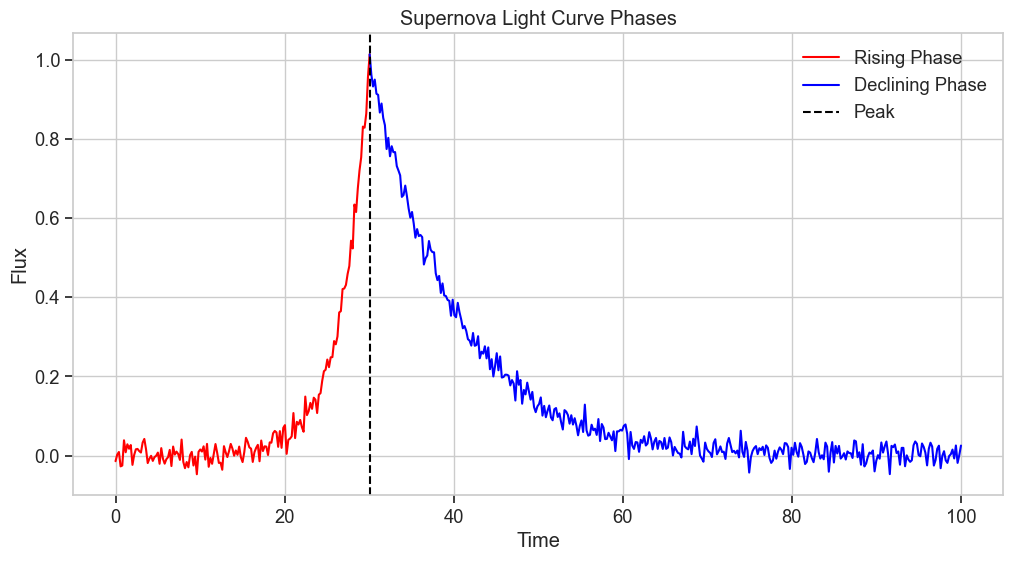

In [18]:
peak_index = lc_supernova['flux'].idxmax()
peak_time = lc_supernova.loc[peak_index, 'time']

# Get the rising phase (from start to peak)
rising_phase = lc_supernova[lc_supernova['time'] <= peak_time]

# Get the declining phase (from peak to end)
declining_phase = lc_supernova[lc_supernova['time'] >= peak_time]

# Visualize the phases
plt.figure(figsize=(12, 6))
plt.plot(rising_phase['time'], rising_phase['flux'], 'r-', label='Rising Phase')
plt.plot(declining_phase['time'], declining_phase['flux'], 'b-', label='Declining Phase')
plt.axvline(x=peak_time, color='k', linestyle='--', label='Peak')
plt.legend()
plt.title('Supernova Light Curve Phases')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.grid(True)
plt.show()

In [38]:
# Convert to numpy arrays and then to PyTorch tensors
X = torch.tensor(rising_phase['time'].values.reshape(-1, 1), dtype=torch.float32)
y = torch.tensor(rising_phase['flux'].values.reshape(-1, 1), dtype=torch.float32)

# Now you can use get_data_loaders
train_loader, val_loader = get_data_loaders(X, y, batch_size=64)

In [20]:
# To verify the shapes and types:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X type:", type(X))
print("y type:", type(y))

X shape: torch.Size([151, 1])
y shape: torch.Size([151, 1])
X type: <class 'torch.Tensor'>
y type: <class 'torch.Tensor'>


In [39]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/1000 - Train Loss: 4.307338 - Val Loss: 2.906328
Epoch 2/1000 - Train Loss: 3.735078 - Val Loss: 2.670400
Epoch 3/1000 - Train Loss: 3.606307 - Val Loss: 2.628301
Epoch 4/1000 - Train Loss: 3.610099 - Val Loss: 2.608468
Epoch 5/1000 - Train Loss: 3.574904 - Val Loss: 2.544071
Epoch 6/1000 - Train Loss: 3.472835 - Val Loss: 2.425509
Epoch 7/1000 - Train Loss: 3.317984 - Val Loss: 2.229890
Epoch 8/1000 - Train Loss: 3.041383 - Val Loss: 2.027401
Epoch 9/1000 - Train Loss: 2.672554 - Val Loss: 1.947869
Epoch 10/1000 - Train Loss: 2.628246 - Val Loss: 2.137288
Epoch 11/1000 - Train Loss: 2.415834 - Val Loss: 1.973062
Epoch 12/1000 - Train Loss: 2.151505 - Val Loss: 1.563631
Epoch 13/1000 - Train Loss: 1.905979 - Val Loss: 1.311434
Epoch 14/1000 - Train Loss: 1.769661 - Val Loss: 1.183498
Epoch 15/1000 - Train Loss: 1.634268 - Val Loss: 1.052964
Epoch 16/1000 - Train Loss: 1.435469 - Val Loss: 1.056371
Epoch 17/1000 - Train Loss: 1.319399 - Val Loss: 1.161426
Epoch 18/1000 - Train L

Final equation: y1 = 0.00087*exp(0.2324*x1)


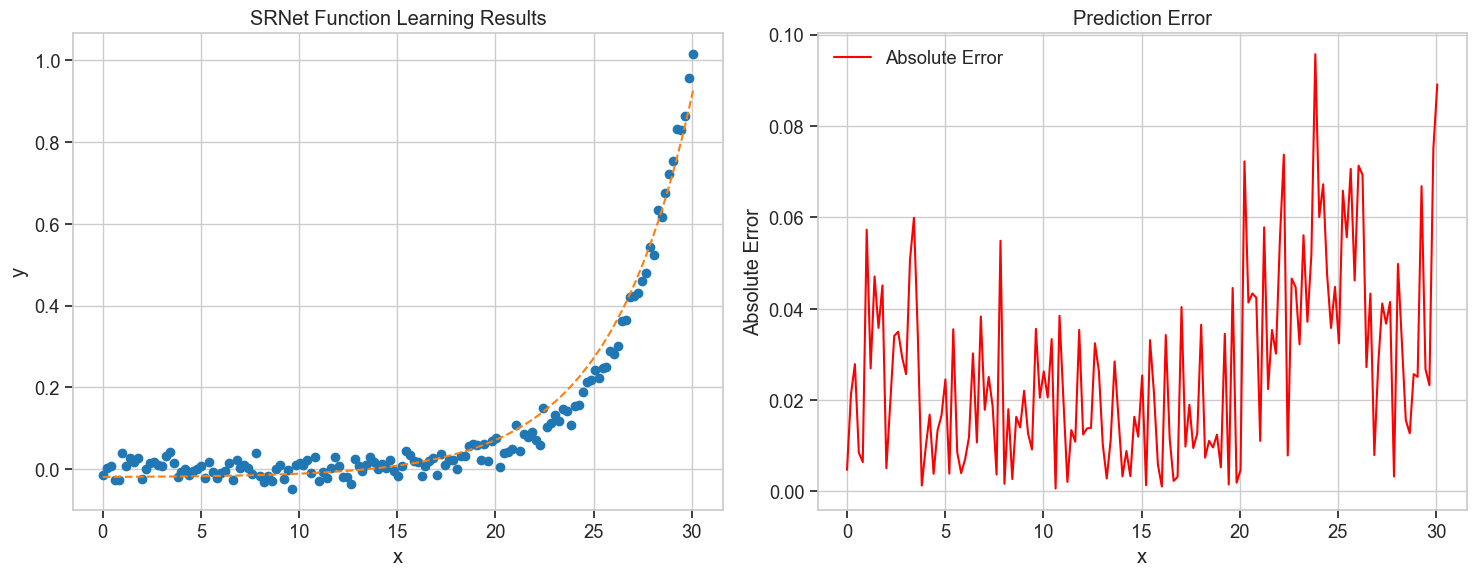

In [40]:
# Get the final equation and evaluate results
device = 'cuda' if torch.cuda.is_available() else 'cpu'


equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y, predictions)

In [41]:
# Convert to numpy arrays and then to PyTorch tensors
X_d = torch.tensor(declining_phase['time'].values.reshape(-1, 1), dtype=torch.float32)
y_d = torch.tensor(declining_phase['flux'].values.reshape(-1, 1), dtype=torch.float32)

# Now you can use get_data_loaders
train_loader_d, val_loader_d = get_data_loaders(X_d, y_d, batch_size=64)

In [42]:
trained_model_d = fn_train(train_loader_d, val_loader_d)

Epoch 1/1000 - Train Loss: 3.180642 - Val Loss: 3.091144
Epoch 2/1000 - Train Loss: 3.096472 - Val Loss: 3.356568
Epoch 3/1000 - Train Loss: 3.078022 - Val Loss: 3.036407
Epoch 4/1000 - Train Loss: 2.763860 - Val Loss: 2.637925
Epoch 5/1000 - Train Loss: 2.459460 - Val Loss: 2.339679
Epoch 6/1000 - Train Loss: 2.327573 - Val Loss: 2.207801
Epoch 7/1000 - Train Loss: 2.303521 - Val Loss: 2.219278
Epoch 8/1000 - Train Loss: 2.333171 - Val Loss: 2.202420
Epoch 9/1000 - Train Loss: 2.288488 - Val Loss: 2.148757
Epoch 10/1000 - Train Loss: 2.230773 - Val Loss: 2.137317
Epoch 11/1000 - Train Loss: 2.188454 - Val Loss: 2.135623
Epoch 12/1000 - Train Loss: 2.151400 - Val Loss: 2.080987
Epoch 13/1000 - Train Loss: 2.092972 - Val Loss: 2.012249
Epoch 14/1000 - Train Loss: 2.042194 - Val Loss: 1.964769
Epoch 15/1000 - Train Loss: 2.014434 - Val Loss: 1.925038
Epoch 16/1000 - Train Loss: 1.964010 - Val Loss: 1.889749
Epoch 17/1000 - Train Loss: 1.919588 - Val Loss: 1.852208
Epoch 18/1000 - Train L

Final equation: y1 = 0.00087*exp(0.2324*x1)


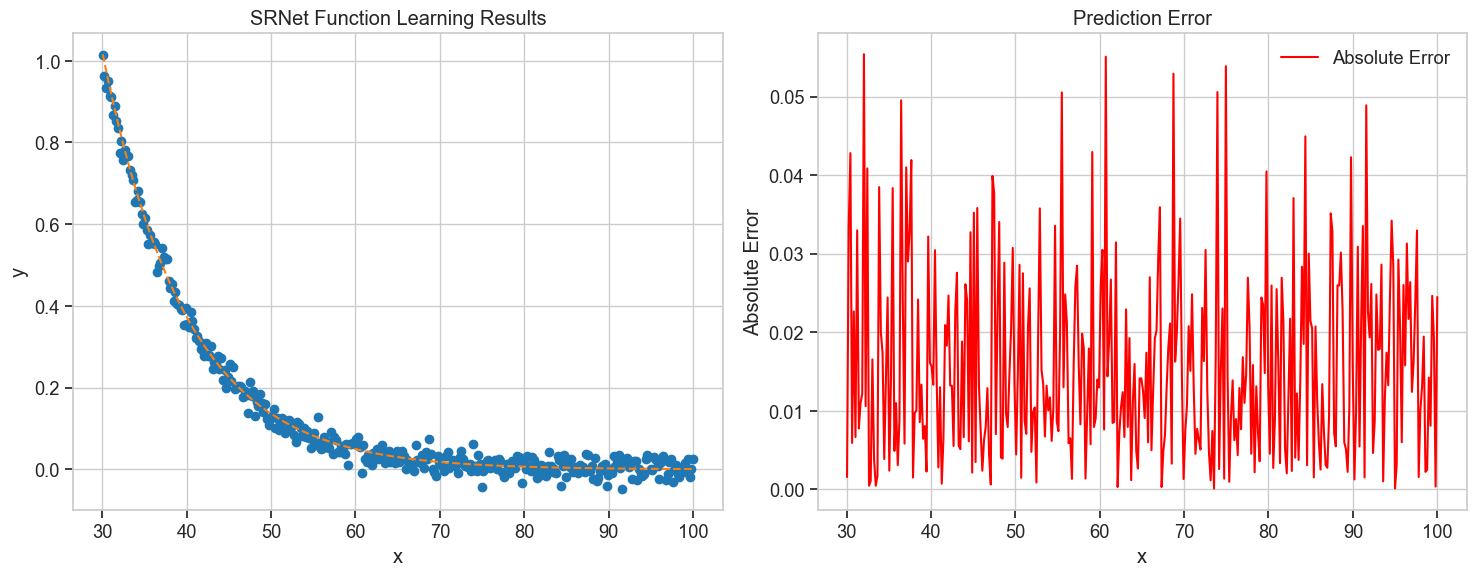

In [43]:
# Get the final equation and evaluate results
device = 'cuda' if torch.cuda.is_available() else 'cpu'


equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model_d.eval()
with torch.no_grad():
    predictions_d = trained_model_d(X_d.to(device))
    predictions_d = predictions_d.cpu()

plot_results(X_d, y_d, predictions_d)

In [44]:
predic = torch.cat((predictions, predictions_d), dim=0)
X = torch.cat((X, X_d), dim=0)
y = torch.cat((y, y_d), dim=0)

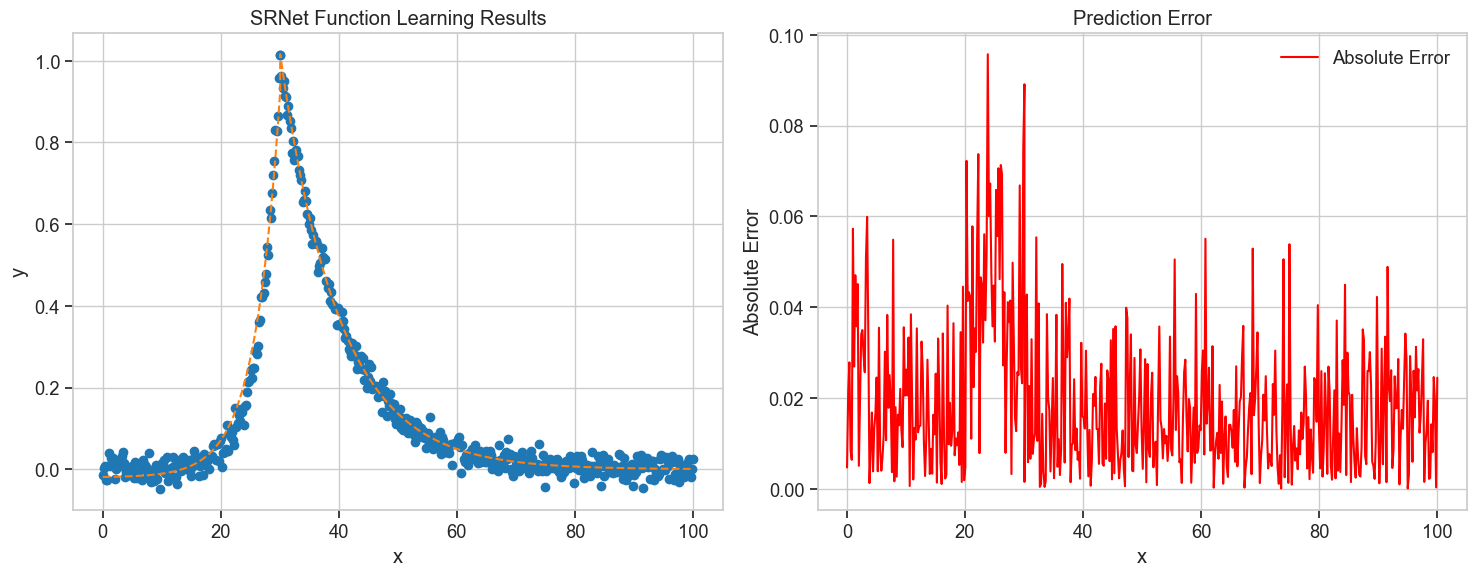

In [45]:
plot_results(X, y, predic)